### Basic imports for the project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

from stable_baselines3.common.callbacks import BaseCallback

2023-04-19 22:45:01.330584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Imports that will emulate the game and an action space

In [2]:
import gym
import retro

### Imports for our PPO algorithm (Proximal Policy Optimization) and for pre-processing (grayscale and frame stacking)

In [3]:
from stable_baselines3 import PPO

from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

### Using GPU for training (with AMD's ROCm), checking if we have access to Cuda (at least 4 times faster training)

In [4]:
import torch
torch.cuda.is_available()

True

### Hijacking the default action space with a wrapper that will allow us to
### create our own combos of buttons

In [5]:
class Discretizer(gym.ActionWrapper):

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False]*env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)

        self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()


class MaRLioDiscretizer(Discretizer):

    def __init__(self, env):
        super().__init__(env=env, 
                         combos=[
            [],
            ["RIGHT"],
            ["RIGHT","Y"],
            ["RIGHT","A"],
            ["RIGHT","Y","A"],
            ["RIGHT","Y","B"],
            ["LEFT","Y"],
            ["LEFT","Y","A"],
            ["LEFT","Y","B"],
            ["A"],
            ["B"]
            ]
        )

### Keeping our combos in a list for an easy visualization using indexing

In [6]:
combos = [
    [],
    ["RIGHT"],
    ["RIGHT","Y"],
    ["RIGHT","A"],
    ["RIGHT","Y","A"],
    ["RIGHT","Y","B"],
    ["LEFT","Y"],
    ["LEFT","Y","A"],
    ["LEFT","Y","B"],
    ["A"],
    ["B"]
    ]

### Storing the path of our custom data.json and scenario.json files into variables

In [7]:
data_path = "./data.json"
scenario_path = "./scenario.json"

### data.json will have memory addresses for things that we want to keep track of
### and will be accessed from the info variable once we run the environment
### scenario.json will be our way of calculating MaRLio's reward
### Let's see how they look like. 

### data.json

````
{
  "info": {
    "checkpoint": {
      "address": 5070,
      "type": "|i1"
    },
    "coins": {
      "address": 8261055,
      "type": "|u1"
    },
    "end_of_level": {
      "address": 8259846,
      "type": "|i1"
    },
    "lives": {
      "address": 8261054,
      "type": "|i1"
    },
    "powerups": {
      "address": 25,
      "type": "|i1"
    },
    "score": {
      "address": 8261428,
      "type": "<u4"
    },
    "xpos": {
      "address": 148,
      "type": "<u2"
    },
    "ypos": {
      "address": 114,
      "type": "<u4"
    },
    "yoshi_coins": {
      "address": 8262690,
      "type": "<u4"
    }
  }
}
````

### scenario.json

````
{
  "crop": [
    0,
    0,
    0,
    0
  ],
  "done": {
    "variables": {
      "lives": {
        "op": "equal",
        "reference": -1
      }
    }
  },
  "reward": {
    "variables": {
      "score": {
        "reward": 1.0
      },
      "coins": {
        "reward": 1.0
      },
      "yoshi_coins": {
        "reward": 1.0
      },
      "xpos": {
        "op": "greater",
        "reference": "last",
        "reward": 10
      },
      "ypos": {
        "op": "less",
        "reference": "last",
        "reward": 10
      },
      "xpos": {
        "op": "less",
        "reference": "last",
        "penalty": 0.1
      },
      "lives": {
        "op": "less",
        "reference": "last",
        "penalty": 1000.0
      },
      "end_of_level": {
        "op": "equal",
        "reference": 1,
        "reward": 1000000.0
      }
    }
  }
}
````

### Let's load our game, Super Mario World (SMW) from the Super Nintendo Entertainment System (SNES)
### using scenario and info kwargs, we can load our custom data.json and scenario.json
### using record kwarg, we can save the training sessions for future viewing

In [8]:
# for train

env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland3", record="./recordings/train/", scenario=scenario_path, info=data_path)

In [9]:
# for pred

# env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland3", record="./recordings/pred/")

In [10]:
# for test

# env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland3")

### This is where we wrap the environment in our own action space

In [11]:
disc_env = MaRLioDiscretizer(env)

In [12]:
obs = disc_env.reset()

### Let's check the index it returns and what combo we get from it

In [13]:
action = disc_env.action_space.sample()
print(action)
combos[action]

2


['RIGHT', 'Y']

### Now we can use that action inside our environment, one frame at a time
### and we can use tuple unpacking, to get access to some important information about our environment

In [14]:
obs, reward, terminated, info = disc_env.step(action)
print(f"score: {reward}\nterminated: {terminated}\ninfo: {info}")

score: 0.0
terminated: False
info: {'end_of_level': 0, 'lives': 4, 'powerups': 0, 'score': 0, 'coins': 0, 'ypos': 159, 'yoshi_coins': 0, 'xpos': 16, 'checkpoint': 0}


### The image we get is a 3-dimensional tensor with a height of 224 pixels, a width of 256 pixels, and 3 color channels (RGB)

In [15]:
obs.shape

(224, 256, 3)

### Let's visualize that frame

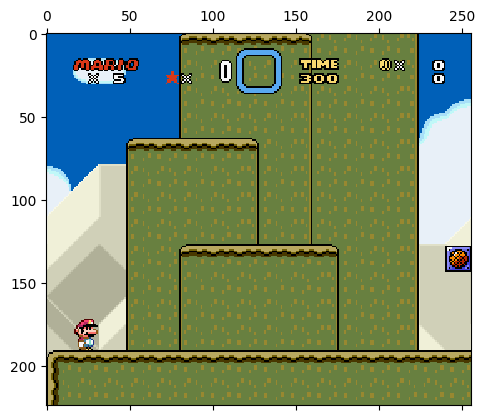

In [16]:
plt.matshow(obs)

In [17]:
# game loop with random actions
# state = disc_env.reset()

# done = False
# while not done:
#     action = disc_env.action_space.sample()
#     state, reward, done, info = disc_env.step(action)
#     disc_env.render()
#     time.sleep(0.005)
# disc_env.render(close=True)

### Let's pre-process our images
### First, grayscale. that'll reduce the size of our environment by 66%
### Second, let's vectorize everything
### Third, let's stack 4 frames, our model will get a sense of momentum

In [18]:
disc_env = GrayScaleObservation(disc_env, keep_dim=True)
disc_env = DummyVecEnv([lambda:disc_env])
disc_env = VecFrameStack(disc_env, 4, channels_order="last")

In [19]:
state = disc_env.reset()

### Let's look at a frame

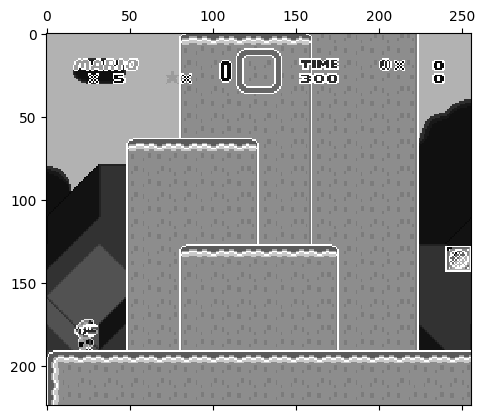

In [20]:
plt.matshow(state[0])

### This time, the (1, 224, 256, 4) shape indicates that the observation is a stack of 4 frames, 
### where each frame is a "color" (grayscale, 1 RGB channel) image with a resolution of 224x256 pixels.

In [21]:
state.shape

(1, 224, 256, 4)

### Taking 4 steps, so we don't have blank frames

In [22]:
for _ in range(3):
    state, reward, done, info = disc_env.step([disc_env.action_space.sample()])

### Let's visualize our stack of frames, with random actions from our list of combos
### We should see some movement

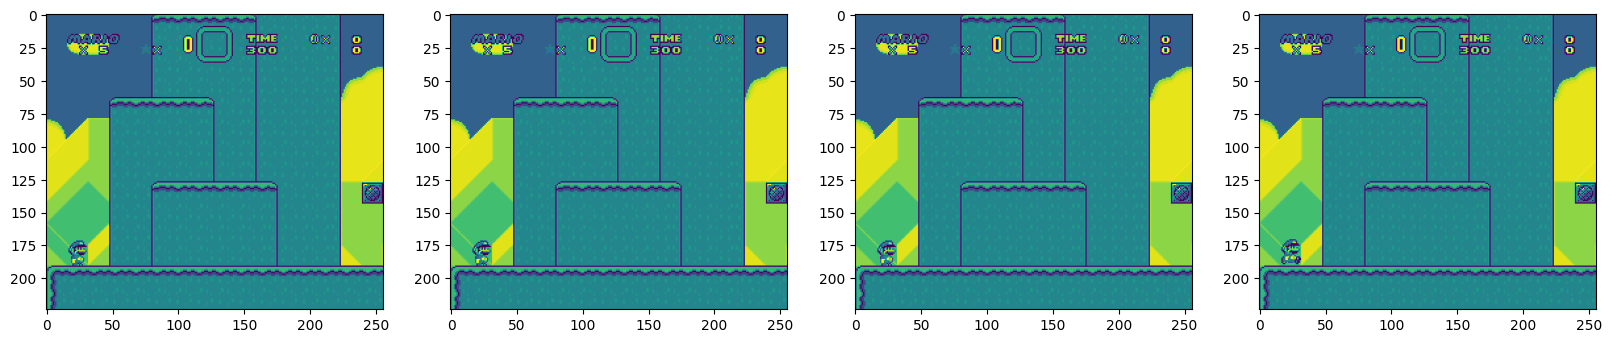

In [23]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [24]:
state = disc_env.reset()

### Defining a class that will create our logs and save our model at every check_freq

In [25]:
# callback helper function

# logs and model saving
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)

        return True

### Creating variables that points to our paths for saving the model and the logs (tensorboard)

In [26]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [27]:
callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

### Keeping track of some hyperparameters for finetuning

In [28]:
# lambda params

# learning_rate = lambda f:f*0.000001
learning_rate = 0.000001
n_steps = 128
clip_range = 0.2
ent_coef = 0.001

### Instance of our PPO algorithm, with the rest of the hyperparameters set to default

In [29]:
model = PPO(
    "CnnPolicy", 
    disc_env, 
    learning_rate=learning_rate, 
    n_steps=n_steps, 
    batch_size=64, 
    n_epochs=10, 
    gamma=0.99, 
    gae_lambda=0.95, 
    clip_range=clip_range, 
    clip_range_vf=None, 
    normalize_advantage=True, 
    ent_coef=ent_coef, 
    vf_coef=0.5, 
    max_grad_norm=0.5, 
    use_sde=False, 
    sde_sample_freq=-1, 
    target_kl=None,  
    tensorboard_log=LOG_DIR, 
    policy_kwargs=None, 
    verbose=0, 
    seed=42, 
    device='auto', 
    _init_setup_model=True
    )

### This is where MaRLio starts his adventure (training)

In [30]:
model.learn(
    total_timesteps=100_000, 
    progress_bar=True, 
    tb_log_name="ppo",
    callback=[
    callback
    ]
)

Output()

### Let's load the models and predict the environment with the models' knowledge

In [47]:
marlio = "best_model_60000.zip"
model = PPO.load(f"./train/{marlio}")
print(f"using {marlio}")

using best_model_60000.zip


In [48]:
state = disc_env.reset()

In [49]:
# game loop for predict

total_reward = 0
action_list = [0]

done = False
while not done:
    action, _ = model.predict(state)
    if action[0] not in action_list:
        action_list.pop()
        action_list.append(action[0])
        print(combos[action_list[0]])
    state, reward, done, info = disc_env.step(action)
    total_reward += reward
    disc_env.render()
    time.sleep(0.004)

print("Total reward:", total_reward)

['RIGHT', 'Y', 'A']
['RIGHT']
['RIGHT', 'Y', 'A']
['LEFT', 'Y', 'A']
['RIGHT', 'Y', 'A']
['LEFT', 'Y']
['RIGHT', 'Y', 'A']
['RIGHT']
['RIGHT', 'Y', 'A']
['LEFT', 'Y', 'A']
['RIGHT', 'Y', 'A']
['LEFT', 'Y', 'A']
['RIGHT', 'Y', 'A']
['RIGHT']
['RIGHT', 'Y', 'A']
['RIGHT']
['RIGHT', 'Y', 'A']
['RIGHT']
['RIGHT', 'Y', 'A']


KeyboardInterrupt: 

# references

In [ ]:
# scenario.json -> https://retro.readthedocs.io/en/latest/integration.html?highlight=scenario#scenario-scenario-json
# metadata.json -> https://retro.readthedocs.io/en/latest/integration.html?highlight=scenario#metadata-json
# data.json -> https://retro.readthedocs.io/en/latest/integration.html?highlight=scenario#data-json

# appendix for operations -> https://retro.readthedocs.io/en/latest/integration.html?highlight=scenario#appendix-operations

In [ ]:
# BINGO

# https://retro.readthedocs.io/en/latest/python.html#render-to-video
# python3.8 -m retro.scripts.playback_movie SuperMarioWorld-Snes-YoshiIsland3-001490.bk2

# tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
# below code not used for now

In [ ]:
# possible playback code below

movie = retro.Movie("./recordings/train/SuperMarioWorld-Snes-YoshiIsland3-000008.bk2")
movie.step()

In [ ]:
env = retro.make(
    game=movie.get_game(),
    state=None,
    # bk2s can contain any button presses, so allow everything
    use_restricted_actions=retro.Actions.ALL,
    players=movie.players,
)
env.initial_state = movie.get_state()
env.reset()

In [ ]:
while movie.step():
    keys = []
    for p in range(movie.players):
        for i in range(env.num_buttons):
            keys.append(movie.get_key(i, p))
    env.step(keys)
    env.render()
    # time.sleep(0.004)

In [ ]:
def record_video(env, policy, out_directory, fps=30):
    images = []
    done = False
    state = env.reset()
    img = env.render(mode="rgb_array")
    images.append(img)
    while not done:
        state = torch.Tensor(state).to(device)
        # Take the action (index) that have the maximum expected future reward given that state
        action, _, _, _ = policy.get_action_and_value(state)
        state, reward, done, info = env.step(
            action.cpu().numpy()
        )  # We directly put next_state = state for recording logic
        img = env.render(mode="rgb_array")
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)